# Dogs Breed: Multi-Label Classification

This article goes through the steps of building a model to predict the breed of a dog.\

This article uses the Stanford Dogs Dataset [1] with ~20000 images and 120 classes.

[1] https://www.kaggle.com/jessicali9530/stanford-dogs-dataset

In [1]:
# First let's import Tensorflow
import tensorflow as tf

In [30]:
# Paths where images are located
FILENAMES = 'gs://tensorflow-samples/datasets/stanford-dogs-dataset/Images/*/*.jpg'

# Paths where labels can be parsed
FOLDERS = 'gs://tensorflow-samples/datasets/stanford-dogs-dataset/Images/*'

TFRECORDS = 'gs://tensorflow-samples/datasets/stanford-dogs-dataset/tfrecords/*'
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [31]:
# Now import some additional libraries
from numpy import zeros
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [32]:
# Get labels from folder's name and create a map to an ID
def get_label_map(path: str) -> (dict, dict):
    #list folders in this path
    folders_name = tf.io.gfile.glob(path)

    labels = []
    for folder in folders_name:
        labels.append(folder.split(sep='/')[-1])

    # Generate a Label Map and Interted Label Map
    label_map = {labels[i]:i for i in range(len(labels))}
    inv_label_map = {i:labels[i] for i in range(len(labels))}
    
    return label_map, inv_label_map

In [33]:
label_map, inv_label_map = get_label_map(FOLDERS)
# List all files in bucket
filepath = tf.io.gfile.glob(FILENAMES)
NUM_TOTAL_IMAGES = len(filepath)

In [34]:
# List all the TFRecords and create a dataset from it
filenames = tf.io.gfile.glob(TFRECORDS)
filenames_dataset = tf.data.Dataset.from_tensor_slices(filenames)

In [35]:
# Create a Dataset composed of TFRecords (paths to bucket)
@tf.function
def get_tfrecord(filename):
    return tf.data.TFRecordDataset(filename, compression_type='GZIP', num_parallel_reads=AUTOTUNE)

In [36]:
@tf.function
def parse_function(example_proto):
    
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenSequenceFeature([], tf.int64, allow_missing=True)
    }
    
    # Parse the input `tf.Example` proto using the dictionary above.
    return tf.io.parse_example(example_proto, feature_description)

In [37]:
# Preprocess Image
@tf.function
def process_image_tfrecord(record):
    
    image = tf.map_fn(tf.io.decode_jpeg, record['image'], dtype=tf.uint8)
    image = tf.map_fn(lambda image: 
                      tf.image.convert_image_dtype(image, dtype=tf.float32), image, dtype=tf.float32)
    
    label = record['label']
    
    return image, label

In [38]:
def build_dataset(dataset, batch_size=BATCH_SIZE):
    
    dataset = dataset.interleave(get_tfrecord, num_parallel_calls=AUTOTUNE)

    dataset = dataset.batch(batch_size=batch_size)
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(process_image_tfrecord, num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [39]:
dataset = build_dataset(filenames_dataset)

In [40]:
image_batch = next(iter(dataset))
images = image_batch[0].numpy()
labels = image_batch[1].numpy()

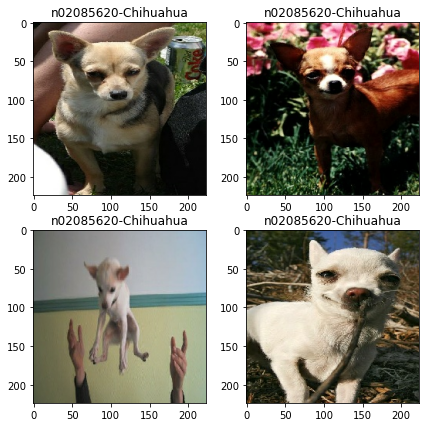

In [41]:
# Plot some images from a batch
fig = plt.figure(figsize=(7,7))

for i in range(4):
    a = fig.add_subplot(2,2,i+1)
    imgplot = plt.imshow(images[i])
    label_index = [i for i,x in enumerate(labels[0] == 1) if x]
    a.set_title(inv_label_map[int(label_index[0])])

In [42]:
train_ds = dataset.take(int(NUM_TOTAL_IMAGES*0.97)).repeat()
test_ds = dataset.skip(int(NUM_TOTAL_IMAGES*0.97)).repeat()

# Model Definition

In [43]:
IMG_SIZE = 224
CHANNELS = 3
IMG_SHAPE = (IMG_SIZE,IMG_SIZE,CHANNELS)

In [51]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [59]:
with strategy.scope():
    base_model = tf.keras.applications.ResNet50V2(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(120)
    ])
    
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=opt, loss=loss, metrics=['acc'])

In [ ]:
tf.summary.trace_off()
tf.summary.trace_on(graph=False, profiler=True)

model.fit(train_ds, validation_data=test_ds, epochs=10, 
          steps_per_epoch=int(NUM_TOTAL_IMAGES/BATCH_SIZE), 
         validation_steps=1)

tf.summary.trace_export('Data Pipeline', profiler_outdir='/home/jupyter/logs/')

# Predict Values

In [ ]:
def process_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, (224,224), method='nearest')
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.expand_dims(image, 0)
    
    return image

In [ ]:
dog_path = '/home/jupyter/ml-samples/tensorflow/dog.jpg'

In [ ]:
dog_image = process_image(dog_path)

In [ ]:
model.predict_classes(dog_image)

In [ ]:
inv_label_map[np.argmax(predict[0])]